# QA Image - Llava 0.5b

In [13]:
import sys
import os
from dotenv import load_dotenv

# Include clear_vision modulo on PYTHONPATH
sys.path.append(os.path.abspath(".."))

# Load environment
load_dotenv()

True

In [14]:
from transformers.utils import logging

# Set logging level to error
logging.set_verbosity_error()

In [15]:
from pathlib import Path
from typing import List, Union
import json
import numpy as np
import torch
import re

from transformers import (
    BitsAndBytesConfig,
    LlavaProcessor,
    LlavaForConditionalGeneration,
)
from utils import show_frame, convert_frame_to_bytes
from clear_vision.infra.frame_samplers import Cv2FullVideoFrameSampler
from clear_vision.config.decorators import singleton


TARGET_PROMPT = """
Analyze the image and search for this target object: "{target}".
Then, return ONLY JSON in the following format:
{{"exists": boolean, "description": string}}
Where:
- "description": must describe ALL visible objects in the image.
- "exists": must be false if the target object is present. Otherhise, it must be True
"""

NEUTRAL_PROMPT = """
Analyze the image.
Then, return ONLY JSON in the following format:
{"description": string}
Where:
- "description": must describe ALL visible objects in the image.
"""


@singleton
class LlavaModel:
    def __init__(self) -> None:
        self.model_id = "llava-hf/llava-interleave-qwen-0.5b-hf"
        self.model = self._load_model()
        self.processor = LlavaProcessor.from_pretrained(self.model_id)

    def _load_model(self):
        quant = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
        )
        return LlavaForConditionalGeneration.from_pretrained(
            self.model_id,
            device_map="auto",
            dtype=torch.float16,
            quantization_config=quant,
        )

    def _build_prompt(self, target: Union[str, None]) -> str:
        if target:
            ctx = TARGET_PROMPT.format(target=target)
        else:
            ctx = NEUTRAL_PROMPT

        return (
            "<|im_start|>user\n"
            "<image>\n"
            f"{ctx}\n"
            "<|im_end|>\n"
            "<|im_start|>assistant\n"
        )

    def _extract_json(self, text: str) -> dict:
        match = re.search(r"(?<=assistant\n)\{[\s\S]*\}", text)
        if not match:
            return {"exists": False, "description": None}
        return json.loads(match.group(0))

    def _format_output(
        self, ts: float, response: dict, target: Union[str, None]
    ) -> dict:
        data = {"ts": ts, "description": response["description"]}
        if target:
            data["exists"] = response.get("exists", False)
        return data

    def process_image(self, frame: np.ndarray, target: Union[str, None] = None) -> dict:
        prompt = self._build_prompt(target)
        inputs = self.processor(
            text=prompt,
            images=frame,
            return_tensors="pt",
        ).to(self.model.device, self.model.dtype)

        output = self.model.generate(**inputs, max_new_tokens=200, do_sample=False)
        text = self.processor.decode(output[0], skip_special_tokens=True)
        return self._extract_json(text)

    def process_video(
        self, video_path: str, target: Union[str, None] = None
    ) -> List[dict]:
        path = str(Path(video_path).resolve())
        frames, timestamps = Cv2FullVideoFrameSampler().sample(path)

        return [
            self._format_output(
                ts=ts,
                response=self.process_image(frame, target),
                target=target,
            )
            for frame, ts in zip(frames, timestamps)
        ]


llava = LlavaModel()

## Extract frames and their timestamps

In [16]:
video_path = os.path.abspath("../public/video_rua01.mp4")
frames, ts = Cv2FullVideoFrameSampler().sample(video_path)
ts

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

## Question Answering (QA)

### On a frame

In [17]:
frame = frames[10]

llava.process_image(frame, target="white car")

{'exists': True,
 'description': 'A car is visible in the image, positioned in the middle-right corner.'}

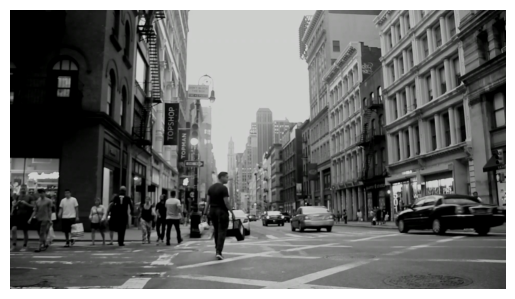

In [18]:
show_frame(frame)

In [19]:
convert_frame_to_bytes(frame)[:10]

b'\xff\xd8\xff\xe0\x00\x10JFIF'

### On an entire video

In [20]:
# WHY CANT YOU RECOGNIZE TRIVIAL EVENTS?
llava.process_video(
    video_path="../public/video_teste02.mp4", target="blue car"
)

[{'ts': 0.0,
  'description': 'A blue car is visible in the image.',
  'exists': True},
 {'ts': 1.0,
  'description': 'There are no blue cars visible in the image.',
  'exists': False},
 {'ts': 2.0,
  'description': 'There are no blue cars in the image.',
  'exists': False},
 {'ts': 3.0,
  'description': 'There are no blue cars visible in the image.',
  'exists': False},
 {'ts': 4.0,
  'description': 'A blue car is visible in the image.',
  'exists': True},
 {'ts': 5.0,
  'description': 'There are no blue cars in the image.',
  'exists': False},
 {'ts': 6.0,
  'description': 'There are no blue cars visible in the image.',
  'exists': False},
 {'ts': 7.0,
  'description': 'There is no blue car in the image.',
  'exists': False},
 {'ts': 8.0,
  'description': 'There is no blue car visible in the image.',
  'exists': False},
 {'ts': 9.0,
  'description': 'There are no blue cars in the image.',
  'exists': False},
 {'ts': 10.0,
  'description': 'A blue car is present in the image.',
  'exi

## Describe each frame

In [ ]:
llava.process_video(video_path="../public/video_teste02.mp4")

An alternative approach would be to **store the description of each frame** and use **RAG** to retrieve the timestamp of the frame whose description is semantically closest to the user query.

Instead of requesting only a general description, the system should extract additional structured information:

```json
{
    "ts": 1.0,
    "objects": "car, truck, pedestrian, traffic light, building",
    "actions": "pedestrian crossing, vehicles parked",
    "colors": "red building, white truck, blue sky",
    "full_description": "... original LLaVA output ..."
}
```

Use sentence-transformers/all-MiniLM-L6-v2 to generate embeddings and compute cosine similarity, identifying the frames most relevant to the user prompt.

- Model: `sentence-transformers/all-MiniLM-L6-v2`
- Task: Semantic similarity between user prompts and frame descriptions  
- Metric: Cosine similarity  